# Multiple and Polynomial Regression

[Resource](https://harvard-iacs.github.io/2018-CS109A/labs/lab-4/solutions/)

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

# Learning Goals

* Implement arbitrary multiple regression models in both sklearn and statsmodels.
* Interpret the coefficient estimates produced by each model, including transformed and dummy variables.

`statsmodels` is focused on the **inference task**: guess good values for the betas and discuss how certain you are in those answers.

`sklearn` is focused on the **prediction task**: Given new data, guess what the response value is. As a result, `statsmodels` has lots of tools to discuss confidence, but isn't great at dealing with test sets. `sklearn` is great at test sets and validations, but can't really discuss uncertainty in the parameters or predictions. In short:
* `sklearn` is about putting a line through it and predicting new values using that line. If the line gives good predictions on the test set, who  cares about anything else?
* `statsmodels` assumes more about how the data were generated, and (if the assumptions are correct) can tell you about uncertainty in the results.

## Some terms
* **R-squared**: An interpretable summary of how well the model did. 1 is perfect, 0 is a trivial baseline model, negative is worse than the trivial model.
* **F-statistic**: A value testing whether we're likely to see these results (or even stronger ones) if none of the predictors actually mattered.
* **Prob (F-statistic)**: The probability that we'd see these results (or even stronger ones) if none of the predictors actually mattered. If this probability is small then either A) some combination of predictors actually matters of B) something rather unlikely has happened.
* **coef**: The estimate of each beta. This has several components:
    * **std err**: The amount we'd expect this value to wiggle if we re-did the data collection and re-ran our model. More data tends to make this wiggle smaller, but sometimes the collected data just isn't enough to pin down a particular value.
    * **t and P>|t|**: Similar to the F-statistic, these measure the probability of seeing coefficients this big (or even bigger) if the given variable didn't actually matter. Small probability doesn't necessarily mean the value matters.
    * **[0.025 0.975]**: Endpoints of the 95% confidence interval. This is an interval drawn in a clever way and which gives us an idea of where the true beta value might plausibly live.

# Part 1: Polynomial Regression, and Revisiting the Cab Data

In [3]:
cab_df = pd.read_csv("../data/dataset_1.txt")
train_data, test_data = train_test_split(cab_df, test_size=0.2, random_state=42)
cab_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [4]:
cab_df.shape

(1250, 2)

In [13]:
# Do some data cleaning
X_train = train_data["TimeMin"].values.reshape(-1,1) / 60 # Convert to seconds
y_train = train_data["PickupCount"].values

X_test = test_data["TimeMin"].values.reshape(-1, 1) / 60 # Convert to seconds
y_test = test_data["PickupCount"].values


def plot_cabs(cur_model, poly_transformer=None):
    # Build the x values for the prediction
    x_vals = np.arange(0, 24,0.1).reshape(-1,1)

    # If needed, build the design matrix
    if poly_transformer:
        design_mat = poly_transformer.fit_transform(x_vals)
    else:
        design_mat = x_vals

    # Make the prediction at each x value
    prediction = cur_model.predict(design_mat)

    # Plot the prediction line and the test data
    plt.plot(x_vals, prediction, ".-", color="k", label="Prediction")
    plt.scatter(X_test, y_test, label="Test Data")

    # Plot labels
    plt.ylabel("Number of Taxi Pickups")
    plt.xlabel("Time of Day (Hours Past Midnight)")
    plt.legend()
    plt.show();

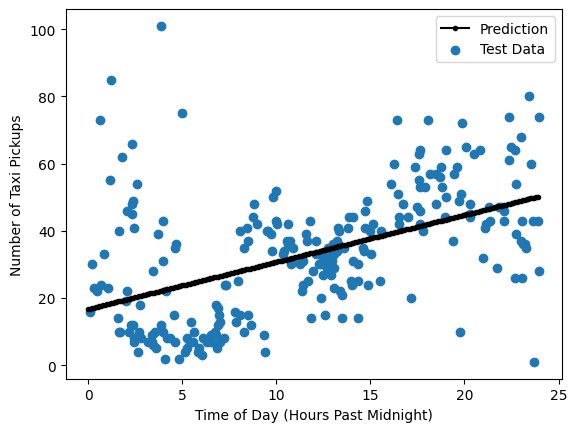

In [14]:
from sklearn.linear_model import LinearRegression

fitted_cab_model0 = LinearRegression().fit(X_train, y_train)
plot_cabs(fitted_cab_model0)

In [16]:
fitted_cab_model0.score(X_test, y_test)

0.240661535615741

We can see that there's still a lot of variation in cab pickups that's not being caught by a linear fit. And the linear fit is predicting massively more pickups at 11:59pm than at 12:00am. However, we can add columns to our design matrix for TimeMin squared, TimeMin cubed, and so on, allowing a wigglier polynomial that will better fit the data.

We'll be using sklearn's `PolynomialFeatures` to take some of the tedium out of building the new design matrix. In fact, if all we want is a basic polynomial formula, it will directly return the new design matrix.

In [30]:
tra = PolynomialFeatures(3, include_bias=True)
xx1 = np.linspace(0,1, 5)
xx2 = np.linspace(9,10, 5)
xx1, xx2


(array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 array([ 9.  ,  9.25,  9.5 ,  9.75, 10.  ]))

In [31]:
xx3 = np.concatenate([xx1.reshape(-1,1),xx2.reshape(-1,1)], axis = 1)
xx3

array([[ 0.  ,  9.  ],
       [ 0.25,  9.25],
       [ 0.5 ,  9.5 ],
       [ 0.75,  9.75],
       [ 1.  , 10.  ]])

In [22]:
xx3 = np.concatenate([xx1.reshape(-1,1), xx2.reshape(-1,1)], axis=1)
xx3, xx3.shape

(array([[ 0.  ,  9.  ],
        [ 0.25,  9.25],
        [ 0.5 ,  9.5 ],
        [ 0.75,  9.75],
        [ 1.  , 10.  ]]),
 (5, 2))

In [32]:
tra = PolynomialFeatures(2, include_bias=False)
tra.fit_transform(xx3)

array([[0.00000e+00, 9.00000e+00, 0.00000e+00, 0.00000e+00, 8.10000e+01],
       [2.50000e-01, 9.25000e+00, 6.25000e-02, 2.31250e+00, 8.55625e+01],
       [5.00000e-01, 9.50000e+00, 2.50000e-01, 4.75000e+00, 9.02500e+01],
       [7.50000e-01, 9.75000e+00, 5.62500e-01, 7.31250e+00, 9.50625e+01],
       [1.00000e+00, 1.00000e+01, 1.00000e+00, 1.00000e+01, 1.00000e+02]])

In [33]:
transformer_3 = PolynomialFeatures(3, include_bias=False)
new_features = transformer_3.fit_transform(X_train)
new_features

array([[6.73333333e+00, 4.53377778e+01, 3.05274370e+02],
       [2.18333333e+00, 4.76694444e+00, 1.04078287e+01],
       [1.41666667e+00, 2.00694444e+00, 2.84317130e+00],
       ...,
       [1.96666667e+01, 3.86777778e+02, 7.60662963e+03],
       [1.17333333e+01, 1.37671111e+02, 1.61534104e+03],
       [1.42000000e+01, 2.01640000e+02, 2.86328800e+03]], shape=(1000, 3))

A few notes on `PolynomialFeatures`:
* The interface is a bit strange. `PolynomialFeatures` is a 'transformer' in sklearn. We'll be using several transformers that learn a transformation on the training data and then apply that transformation on future data. On these (more typical) transformers, it makes sense to have a `.fit()` and a separate `.transform()`. With `PolynomialFeatures`, the `.fit()` is pretty trivial, and we often fit and transform in one command, as seen above.
* You rarely want to `include_bias` (a column of all 1s), since sklearn will add it automatically and statsmodels can just `add_constant` right before you fit to the design matrix.
* If you want polynomial features for several different variables, you should call `.fit_transform()` separately on each column and append all the results to the design matrix (unless you also want interaction terms between the newly-created features). See `np.concatenate` for joining arrays.

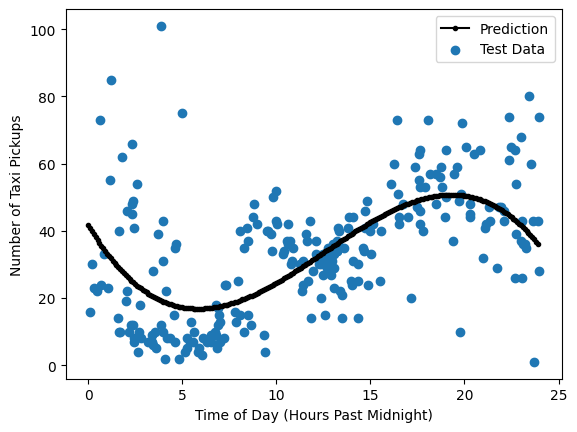

In [35]:
# Putting the previous code here just for clarity
transformer_3 = PolynomialFeatures(3, include_bias=False)
new_features = transformer_3.fit_transform(X_train)

fitted_cab_model3 = LinearRegression().fit(new_features, y_train)
plot_cabs(fitted_cab_model3, transformer_3)

**Exercise**

1. Calculate the polynomial model's R2 performance on the test set.
1. Does the polynomial model improve on the purely linear model?
1. Make a residual plot for the polynomial model. What does this plot tell us about the model?

In [53]:
print("Original Model R-Squared:", fitted_cab_model0.score(X_test, y_test))
print("Feature Model R-squared:", fitted_cab_model3.score(transformer_3.fit_transform(X_test), y_test))

Original Model R-Squared: 0.240661535615741
Feature Model R-squared: 0.3341251257077854


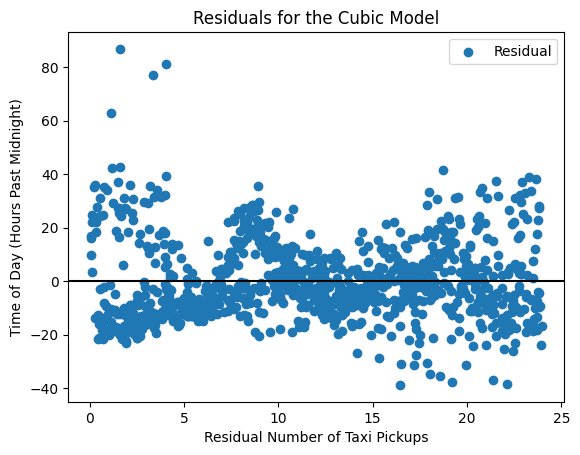

In [47]:
design_mat = transformer_3.fit_transform(X_train)

prediction = fitted_cab_model3.predict(design_mat)
residual = y_train - prediction
plt.scatter(X_train, residual, label="Residual")
plt.axhline(0, color="k")

plt.title("Residuals for the Cubic Model")
plt.xlabel("Residual Number of Taxi Pickups")
plt.ylabel("Time of Day (Hours Past Midnight)")
plt.legend();

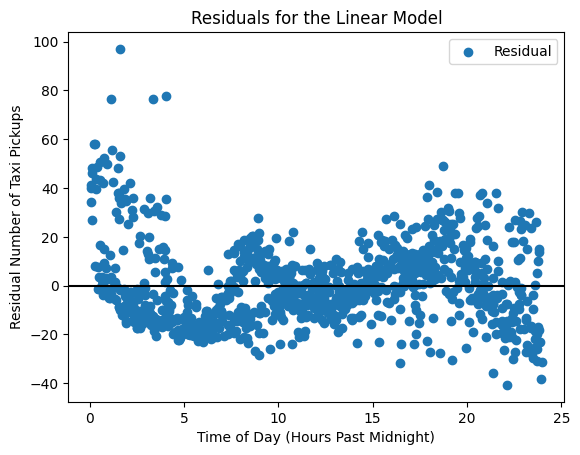

In [48]:
design_mat = X_train

prediction = fitted_cab_model0.predict(design_mat)
residual = y_train - prediction
plt.scatter(X_train, residual, label="Residual")
plt.axhline(0, color="k")

plt.title("Residuals for the Linear Model")
plt.ylabel("Residual Number of Taxi Pickups")
plt.xlabel("Time of Day (Hours Past Midnight)")
plt.legend();

Yes, the test set R-squared is higher, and the visual fit to both data sets is much better. It even looks like the predicted number of pickups at 11:59pm and 12:00am are nearly equal.

Moreover, the residuals are much more evenly spread than with the linear model, but they still don't look like an even spread of Gaussian noise. This makes it unlikely that the statsmodel assumptions are valid, and we might want to be careful about trusting confidence intervals, etc, and we may want to search for other models entirely.

## Other features

Polynomial features are not the only constructed features that help fit the data. because these data have a 24 hour cycle, we may want to build features that follow such a cycle. Different feature transformations are appropriate for different types of data. For instance certain feature transformations have been developed for geographical data.

# Part 2: Multiple Regression and Exploring the Football Data

Let's move on to a truly interesting dataset. The data imported below were scraped by some guy and record various facts about players in the English Premier League. Our goa will be to fit models that predict the players' market value (what the player could earn when hired by a new team), as estimated by tranfermrkt.com.